In [ ]:
# !pip install transformers

In [1]:
import os, gc, sys, time, collections, random
import numpy as np
import pandas as pd

from typing import Dict, Optional, Union, Any, List, Tuple

from pathlib import Path
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold

import torch
import torch.nn as nn

import torch.utils.data as D
from torch.utils.data.dataset import Dataset, IterableDataset
from torch.utils.data.dataloader import DataLoader

from transformers import DistilBertTokenizerFast
from transformers import DistilBertModel
from transformers import BertTokenizerFast
from transformers import BertModel
from transformers import Trainer
from transformers import AutoModel, AutoTokenizer, AutoConfig, AutoModelForSequenceClassification
from transformers.data.processors.utils import InputFeatures
from transformers import TrainingArguments
from transformers.trainer_utils import EvalLoopOutput
from transformers.trainer import logging
from transformers.file_utils import is_torch_tpu_available, is_sagemaker_mp_enabled
from transformers.trainer_pt_utils import find_batch_size, nested_concat, nested_numpify, nested_truncate, nested_detach

### Folders and Dataframes

In [2]:
DATA_PATH = Path('/home/commonlit/data/')
assert DATA_PATH.exists()
MODELS_PATH = Path('/home/commonlit/models/')
if not MODELS_PATH.exists():
    os.mkdir(MODELS_PATH)
assert MODELS_PATH.exists()

In [3]:
!ls {DATA_PATH}

commonlit_lm	  commonlitreadabilityprize.zip  test.csv	 train.csv
commonlit_lm.zip  sample_submission.csv		 train-orig.csv  train_duo.csv


In [4]:
train_df = pd.read_csv(DATA_PATH/'train.csv')
test_df = pd.read_csv(DATA_PATH/'test.csv')
sample_df = pd.read_csv(DATA_PATH/'sample_submission.csv')

In [5]:
train_df

,id,url_legal,license,excerpt,target,standard_error
0,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009
1,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009
2,c12129c31,NaN,NaN,"Patty concluded to move very slowly, thinking ...",-0.340259,0.464009
3,c12129c31,NaN,NaN,"Patty concluded to move very slowly, thinking ...",-0.340259,0.464009
4,c12129c31,NaN,NaN,"At last the game was concluded, as Roger Farri...",-0.340259,0.464009
...,...,...,...,...,...,...
2846,25ca8f498,https://sites.ehe.osu.edu/beyondpenguins/files...,CC BY-SA 3.0,When you think of dinosaurs and where they liv...,1.711390,0.646900
2847,2c26db523,https://en.wikibooks.org/wiki/Wikijunior:The_E...,CC BY-SA 3.0,So what is a solid? Solids are usually hard be...,0.189476,0.535648
2848,cd19e2350,https://en.wikibooks.org/wiki/Wikijunior:The_E...,CC BY-SA 3.0,The second state of matter we will discuss is ...,0.255209,0.483866
2849,15e2e9e7a,https://en.wikibooks.org/wiki/Geometry_for_Ele...,CC BY-SA 3.0,Solids are shapes that you can actually touch....,-0.215279,0.514128


In [6]:
train_df[train_df['excerpt'].str.contains('Robin Hood')]

,id,url_legal,license,excerpt,target,standard_error
231,21ea485fb,NaN,NaN,A little within the wood there was a fair cast...,-1.302688,0.450399
233,a04741371,NaN,NaN,"The king dwelt for many months in Nottingham, ...",-0.714009,0.506864
234,5cb5ab998,NaN,NaN,"When they drew near Nottingham, all the people...",-1.541347,0.478166
235,622f6215e,NaN,NaN,About this time there was living in Nottingham...,-2.054284,0.538084


In [7]:
train_df[train_df['id'] == '21ea485fb']['excerpt'].values

array(['A little within the wood there was a fair castle, with a double moat, and surrounded by stout walls. Here dwelt that noble knight, Sir Richard Lee, to whom Robin Hood had lent the four hundred pounds to redeem his land.\nHe saw the little company of outlaws fighting their way along, so he hastened to call them to come and take shelter in his castle.\n"Welcome art thou, Robin Hood! Welcome!" he cried, as he led them in. "Much I thank thee for thy comfort and courtesy and great kindness to me in the forest. There is no man in the world I love so much as thee. For all the proud Sheriff of Nottingham, here thou shalt be safe!—Shut the gates, and draw the bridge, and let no man come in!" he shouted to his retainers. "Arm you well; make ready; guard the walls! One thing, Robin, I promise thee: here shalt thou stay for twelve days as my guest, to sup, and eat, and dine."\nSwiftly and readily tables were laid and cloths spread, and Robin Hood and his merry men sat down to a good meal.'

In [8]:
train_df[train_df['id'] == '0bf29d257']['target']

1305   -3.351956
1306   -3.351956
Name: target, dtype: float64

### Normalize

In [9]:
train_df['target'].describe()

count    2851.000000
mean       -0.957998
std         1.033003
min        -3.676268
25%        -1.686273
50%        -0.908395
75%        -0.203133
max         1.711390
Name: target, dtype: float64

In [10]:
train_target_mean = train_df['target'].mean()
train_target_std = train_df['target'].std()
train_df['normalized_target'] = (train_df['target'] - train_target_mean) / train_target_std

In [11]:
train_target_mean, train_target_std

(-0.9579984513405823, 1.0330032114342367)

In [12]:
train_df['normalized_target'].describe()

count    2.851000e+03
mean    -1.993806e-17
std      1.000000e+00
min     -2.631424e+00
25%     -7.050067e-01
50%      4.801823e-02
75%      7.307481e-01
max      2.584105e+00
Name: normalized_target, dtype: float64

In [13]:
train_df['normalized_target_check'] = train_df['normalized_target'] * train_target_std + train_target_mean

In [14]:
train_df.head(30)

,id,url_legal,license,excerpt,target,standard_error,normalized_target,normalized_target_check
0,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009,0.598003,-0.340259
1,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009,0.598003,-0.340259
2,c12129c31,NaN,NaN,"Patty concluded to move very slowly, thinking ...",-0.340259,0.464009,0.598003,-0.340259
3,c12129c31,NaN,NaN,"Patty concluded to move very slowly, thinking ...",-0.340259,0.464009,0.598003,-0.340259
4,c12129c31,NaN,NaN,"At last the game was concluded, as Roger Farri...",-0.340259,0.464009,0.598003,-0.340259
5,85aa80a4c,NaN,NaN,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805,0.622095,-0.315372
6,b69ac6792,NaN,NaN,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676,0.365808,-0.580118
7,dd1000b26,NaN,NaN,And outside before the palace a great garden w...,-1.054013,0.450007,-0.092947,-1.054013
8,dd1000b26,NaN,NaN,And outside before the palace a great garden w...,-1.054013,0.450007,-0.092947,-1.054013
9,37c1b32fb,NaN,NaN,Once upon a time there were Three Bears who li...,0.247197,0.510845,1.166691,0.247197


In [15]:
# !pip install seaborn

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='target'>

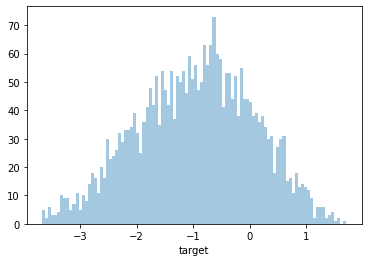

In [17]:
sns.distplot(train_df['target'],bins=100,kde=False)

### Configuration

In [18]:
import yaml

In [19]:
class CONFIG():
    batch_size = 24
    max_len = 256
    num_workers = 4
    epochs = 30
    pretrained_transformers_model = f'roberta-base'
    target_field = 'target'

In [20]:
cfg = CONFIG()
cfg.model_name = 'roberta-base'
cfg.num_folds = 6

In [21]:
cfg.train_target_std = float(train_target_std)
cfg.train_target_mean = float(train_target_mean)

In [22]:
# assert Path(cfg.pretrained_transformers_model).exists()

In [23]:
vars(cfg)

{'model_name': 'roberta-base',
 'num_folds': 6,
 'train_target_std': 1.0330032114342367,
 'train_target_mean': -0.9579984513405823}

In [24]:
!mkdir {MODELS_PATH}/facebook

mkdir: cannot create directory ‘/home/commonlit/models/facebook’: File exists


In [25]:
with open(f'{MODELS_PATH}/{cfg.model_name}.yaml', 'w') as file:
    documents = yaml.dump(vars(cfg), file)

### Prepare Cross Validation

In [26]:
target = train_df[cfg.target_field].to_numpy()

In [27]:
num_bins = int(np.floor(np.log2(len(train_df))) + 1)
train_df.loc[:, 'bins'] = pd.cut(train_df[cfg.target_field], bins=num_bins, labels=False)

In [28]:
train_df[[cfg.target_field, 'bins']].groupby(['bins']).agg(['mean', 'count'])

target      
          mean count
bins                
0    -3.411708    44
1    -2.969369    79
2    -2.526589   172
3    -2.106393   269
4    -1.652995   368
5    -1.201392   420
6    -0.748350   485
7    -0.309794   411
8     0.130016   312
9     0.561006   185
10    0.978923    83
11    1.399764    23

In [29]:
kf = StratifiedKFold(n_splits=cfg.num_folds)

In [30]:
for i, (t_, v_) in enumerate(kf.split(X=train_df, y=train_df.bins.values)):
    train_df.loc[v_, 'kfold'] = i

In [31]:
train_df['kfold'] = train_df['kfold'].astype(np.uint8)

In [32]:
train_df = train_df.drop('bins', axis=1)

In [33]:
train_df

,id,url_legal,license,excerpt,target,standard_error,normalized_target,normalized_target_check,kfold
0,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009,0.598003,-0.340259,0
1,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009,0.598003,-0.340259,0
2,c12129c31,NaN,NaN,"Patty concluded to move very slowly, thinking ...",-0.340259,0.464009,0.598003,-0.340259,0
3,c12129c31,NaN,NaN,"Patty concluded to move very slowly, thinking ...",-0.340259,0.464009,0.598003,-0.340259,0
4,c12129c31,NaN,NaN,"At last the game was concluded, as Roger Farri...",-0.340259,0.464009,0.598003,-0.340259,0
...,...,...,...,...,...,...,...,...,...
2846,25ca8f498,https://sites.ehe.osu.edu/beyondpenguins/files...,CC BY-SA 3.0,When you think of dinosaurs and where they liv...,1.711390,0.646900,2.584105,1.711390,5
2847,2c26db523,https://en.wikibooks.org/wiki/Wikijunior:The_E...,CC BY-SA 3.0,So what is a solid? Solids are usually hard be...,0.189476,0.535648,1.110814,0.189476,5
2848,cd19e2350,https://en.wikibooks.org/wiki/Wikijunior:The_E...,CC BY-SA 3.0,The second state of matter we will discuss is ...,0.255209,0.483866,1.174447,0.255209,5
2849,15e2e9e7a,https://en.wikibooks.org/wiki/Geometry_for_Ele...,CC BY-SA 3.0,Solids are shapes that you can actually touch....,-0.215279,0.514128,0.718990,-0.215279,5


In [34]:
train_df[[cfg.target_field, 'kfold']].groupby(['kfold']).agg(['mean', 'count'])

target      
           mean count
kfold                
0     -0.963735   476
1     -0.947037   475
2     -0.944495   475
3     -0.965707   475
4     -0.956770   475
5     -0.970235   475

In [35]:
bin_list = list(range(num_bins))
random.shuffle(bin_list)
bin_list

[8, 2, 4, 1, 3, 9, 7, 5, 10, 0, 6, 11]

In [36]:
train_df['normalized_target'].mean()

-1.9938063437673803e-17

### Metrics

In [37]:
def rmse_score(y_true, y_pred):
    return np.sqrt(np.mean((y_pred - y_true) ** 2))

def rmse_score_2(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [38]:
a = np.random.rand(10)
b = np.random.rand(10)

In [39]:
rmse_score(a, b), rmse_score_2(a, b)

(0.5210247053821492, 0.5210247053821492)

### Prepare train test split

In [40]:
def create_split(fold = [1]):
    valid_df = train_df[train_df['kfold'].isin(fold)]
    valid_text = valid_df['excerpt'].values
    valid_target = valid_df[cfg.target_field].values
    training_df = train_df[~train_df['kfold'].isin(fold)]
    train_text = training_df['excerpt'].values
    train_target = training_df[cfg.target_field].values
    return train_text, train_target, valid_text, valid_target

In [41]:
train_text, train_target, valid_text, valid_target = create_split([0])
len(train_text), len(valid_text)

(2375, 476)

### Prepare Tokenizers

In [42]:
tokenizer = AutoTokenizer.from_pretrained(cfg.pretrained_transformers_model)
# Save the tokenizer so that you can download the files and move it to a Kaggle dataset.
# tokenizer.save_pretrained(cfg.save_dir)

In [43]:
encoded_dict = tokenizer(train_df['excerpt'].values[0],
                                return_tensors='pt',
                                max_length=cfg.max_len,
                                padding='max_length',
                                truncation=True,
                                return_token_type_ids=True)
decoded = tokenizer.decode(encoded_dict["input_ids"].squeeze())
decoded

'<s>When the young people returned to the ballroom, it presented a decidedly changed appearance. Instead of an interior scene, it was a winter landscape.\nThe floor was covered with snow-white canvas, not laid on smoothly, but rumpled over bumps and hillocks, like a real snow field. The numerous palms and evergreens that had decorated the room, were powdered with flour and strewn with tufts of cotton, like snow. Also diamond dust had been lightly sprinkled on them, and glittering crystal icicles hung from the branches.\nAt each end of the room, on the wall, hung a beautiful bear-skin rug.\nThese rugs were for prizes, one for the girls and one for the boys. And this was the game.\nThe girls were gathered at one end of the room and the boys at the other, and one end was called the North Pole, and the other the South Pole. Each player was given a small flag which they were to plant on reaching the Pole.\nThis would have been an easy matter, but each traveller was obliged to wear snowshoes

In [44]:
encoded_dict.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [45]:
encoded_dict.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [46]:
encoded_dict['input_ids'].shape

torch.Size([1, 256])

In [47]:
def convert_to_list(t):
    return t.flatten().long()

class CommonLitDataset(nn.Module):
    def __init__(self, text, target, tokenizer, max_len=128):
        self.excerpt = text
        self.target = target
        self.max_len = max_len
        self.tokenizer = tokenizer
    
    def __getitem__(self, idx):
        encode = self.tokenizer(self.excerpt[idx],
                                return_tensors='pt',
                                max_length=self.max_len,
                                padding='max_length',
                                truncation=True)
        return InputFeatures(input_ids=convert_to_list(encode['input_ids']),
                      attention_mask=convert_to_list(encode['attention_mask']),
                      label=torch.tensor(self.target[idx]))
    
    def __len__(self):
        return len(self.excerpt)

In [48]:
def create_train_valid_ds(tokenizer, train_text, train_target, valid_text, valid_target):
    train_ds = CommonLitDataset(train_text, train_target, tokenizer, cfg.max_len)
    valid_ds = CommonLitDataset(valid_text, valid_target, tokenizer, cfg.max_len)
    return train_ds, valid_ds

In [49]:
# encode.keys(), target.shape, encode['input_ids'].shape, encode['attention_mask'].shape

In [50]:
# encode['input_ids'][0].squeeze()

### Model

In [51]:
# You can use a Transformer model of your choice.
# transformer_model = DistilBertModel.from_pretrained(cfg.pretrained_transformers_model)
transformer_model = AutoModel.from_pretrained(cfg.pretrained_transformers_model)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [52]:
# dict(transformer_out)['last_hidden_state'].shape

In [53]:
# torch.mean(transformer_out.last_hidden_state, axis=1).shape

In [54]:
# sample_layer = nn.Linear(768, 1)

In [55]:
model_config = AutoConfig.from_pretrained(cfg.pretrained_transformers_model)

In [56]:
model_config

RobertaConfig {
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.6.0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

In [57]:
from torch.nn import functional as F

In [58]:
from transformers import PreTrainedModel

class CommonLitModel(PreTrainedModel):
    def __init__(self):
        super(PreTrainedModel, self).__init__()
        self.transformer_model = AutoModel.from_pretrained(cfg.pretrained_transformers_model)
        self.drop = nn.Dropout(0.5)
        self.config = AutoConfig.from_pretrained(cfg.pretrained_transformers_model)
        self.layer_norm = nn.LayerNorm(self.config.hidden_size)
        self.out = nn.Linear(self.config.hidden_size, 1)
        self._init_weights(self.layer_norm)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        if isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        
    def forward(self, input_ids, attention_mask):
        transformer_out = self.transformer_model(input_ids=input_ids.squeeze(), attention_mask=attention_mask.squeeze(), 
                                                 output_hidden_states=True)
        x = transformer_out.pooler_output
#         x = transformer_out.last_hidden_state[:, 0, :] # N, C, X
#         x = torch.mean(transformer_out.hidden_states[-2], axis=1)
#         x2 = torch.mean(transformer_out.encoder_hidden_states[-2], axis=1)
#         x = torch.cat([x, x2], axis=1)
        x = self.layer_norm(x)
        x = self.drop(x)
        x = self.out(x)
        return x
    
    def floating_point_ops(self, inputs: Dict[str, Union[torch.Tensor, Any]]):
        """
        For models that inherit from :class:`~transformers.PreTrainedModel`, uses that method to compute the number of
        floating point operations for every backward + forward pass. If using another model, either implement such a
        method in the model or subclass and override this method.
        Args:
            inputs (:obj:`Dict[str, Union[torch.Tensor, Any]]`):
                The inputs and targets of the model.
        Returns:
            :obj:`int`: The number of floating-point operations.
        """
        return 0

In [59]:
model = CommonLitModel()

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [60]:
encoded_dict.token_type_ids

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [61]:
encoded_dict.token_type_ids.shape

torch.Size([1, 256])

In [62]:
transformer_model = transformer_model.cuda()
sample_out = transformer_model(encoded_dict.input_ids.cuda(), encoded_dict.attention_mask.cuda(), encoded_dict.token_type_ids.cuda(), output_hidden_states=True)

In [63]:
sample_out.keys()

odict_keys(['last_hidden_state', 'pooler_output', 'hidden_states'])

In [64]:
sample_x = torch.mean(sample_out.hidden_states[-1], axis=1)

In [65]:
torch.cat([sample_x, sample_x], axis=1).shape

torch.Size([1, 1536])

In [66]:
sample_out.hidden_states[-1].shape, sample_out.hidden_states[-1][:, 0, :].shape

(torch.Size([1, 256, 768]), torch.Size([1, 768]))

In [67]:
train_ds, valid_ds = create_train_valid_ds(tokenizer, train_text, train_target, valid_text, valid_target)

In [68]:
encode = train_ds[0]

In [69]:
encode.attention_mask.unsqueeze(0).shape, encoded_dict.input_ids.shape

(torch.Size([1, 256]), torch.Size([1, 256]))

In [70]:
sample_out = transformer_model(encode.input_ids.unsqueeze(0).cuda(), encode.attention_mask.unsqueeze(0).cuda())

### Training

In [96]:
import os
os.environ['WANDB_DISABLED'] = "true"

In [108]:
criterion = nn.MSELoss()

kl_loss = nn.KLDivLoss(reduction = 'batchmean')

def loss_fct(yhat, y):
    return criterion(yhat, y) * 0.7 + 0.3 * kl_loss(yhat, y)

loss_fct = nn.MSELoss()

def loss_fct(yhat, y):
    return torch.sqrt(criterion(yhat, y))

In [109]:
def create_training_args(fold):
    training_args = TrainingArguments(
        output_dir=str(MODELS_PATH/f"{cfg.model_name.replace('/', '_')}-{fold}"),
        overwrite_output_dir=True,
        do_train=True,
        do_eval=True,
        per_device_train_batch_size=cfg.batch_size,
        per_device_eval_batch_size=cfg.batch_size,
        num_train_epochs=cfg.epochs,
        logging_strategy="epoch",
        logging_first_step=True,
        save_steps=40000,
        fp16=True,
        evaluation_strategy="epoch",
        save_total_limit = 3,
        load_best_model_at_end=True,
        metric_for_best_model='rmse',
        greater_is_better=False,
        gradient_accumulation_steps=1,
        learning_rate=5e-5,
        report_to=None
    )
    return training_args

In [110]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    return {'rmse': rmse_score_2(logits, labels)}

In [111]:
def model_init():
    return CommonLitModel()

In [112]:
tokenizer = AutoTokenizer.from_pretrained(cfg.pretrained_transformers_model)

In [113]:
logger = logging.get_logger(__name__)

class CommonLitTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        input_ids = inputs.pop("input_ids")
        attention_mask = inputs.pop("attention_mask")
        outputs = model(input_ids, attention_mask)
        logits = outputs
        loss = loss_fct(logits.flatten(),
                        labels.float().flatten())
        zero_cat = torch.zeros([1, 1]).to(outputs.device)
        return (loss, torch.cat([zero_cat, outputs])) if return_outputs else loss

In [114]:
!rm -rf /home/commonlit/models/{cfg.model_name.replace('/', '_')}-*

In [115]:
fold = 4

training_args = create_training_args(fold)
tokenizer = AutoTokenizer.from_pretrained(cfg.pretrained_transformers_model)
train_text, train_target, valid_text, valid_target = create_split([fold])
train_ds, valid_ds = create_train_valid_ds(tokenizer, train_text, train_target, valid_text, valid_target)

trainer = CommonLitTrainer(
    model_init=model_init,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=valid_ds,
    compute_metrics=compute_metrics
)

Using the `WAND_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [116]:
# !pip install optuna

In [117]:
def my_hp_space(trial):
    return {
        "learning_rate": trial.suggest_float("learning_rate", 5e-6, 5e-3, log=True),
        "num_train_epochs": trial.suggest_int("num_train_epochs", 1, 30),
        "seed": trial.suggest_int("seed", 1, 40),
        "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [8, 16, 48]),
    }

In [118]:
trainer.hyperparameter_search(direction="minimize", hp_space=my_hp_space)

[I 2021-06-21 14:53:45,709] A new study created in memory with name: no-name-51ccacb5-ac60-4884-a97c-ce646eb2b3e4
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch,Training Loss,Validation Loss,Rmse
1,0.882000,0.563422,0.572760
2,0.690700,0.803273,0.815880
3,0.593100,0.605514,0.614652
4,0.536500,0.547512,0.556419
5,0.468400,0.614465,0.621855
6,0.455600,0.657547,0.664550
7,0.412600,0.655583,0.662059
8,0.381700,0.774476,0.780572
9,0.368000,0.588813,0.595202
10,0.345600,0.657782,0.666393


[I 2021-06-21 15:06:09,873] Trial 0 finished with value: 0.6793746948242188 and parameters: {'learning_rate': 2.9508198532984878e-05, 'num_train_epochs': 16, 'seed': 14, 'per_device_train_batch_size': 48}. Best is trial 0 with value: 0.6793746948242188.
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch,Training Loss,Validation Loss,Rmse
1,1.238800,0.987888,1.049906
2,1.118600,0.993802,1.037834
3,1.106000,1.049417,1.085193
4,1.095700,0.997551,1.039663
5,1.072100,0.986388,1.039539
6,1.054800,0.987894,1.037369
7,1.069600,0.995690,1.038679
8,1.052000,0.989757,1.036910
9,1.050500,0.988864,1.037004
10,1.053400,0.986947,1.038258


[I 2021-06-21 15:14:21,359] Trial 1 finished with value: 1.0382579565048218 and parameters: {'learning_rate': 0.00022987262863758152, 'num_train_epochs': 10, 'seed': 20, 'per_device_train_batch_size': 48}. Best is trial 0 with value: 0.6793746948242188.
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch,Training Loss,Validation Loss,Rmse
1,1.378800,0.997222,1.039480
2,1.156300,1.160051,1.206393
3,1.109100,0.996054,1.068195
4,1.070200,0.990530,1.036948


[I 2021-06-21 15:25:57,763] Trial 2 finished with value: 1.036948323249817 and parameters: {'learning_rate': 0.0030341715113685963, 'num_train_epochs': 4, 'seed': 10, 'per_device_train_batch_size': 8}. Best is trial 0 with value: 0.6793746948242188.
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch,Training Loss,Validation Loss,Rmse
1,1.005000,0.578716,0.589134
2,0.791600,0.673950,0.684949
3,0.733900,0.682804,0.691496
4,0.662600,0.658343,0.666322
5,0.596900,0.613603,0.619464
6,0.548800,0.609600,0.615129
7,0.504600,0.543517,0.548680
8,0.493900,0.581434,0.586336
9,0.452700,0.653361,0.657883
10,0.443900,0.594051,0.598323


[I 2021-06-21 15:35:14,590] Trial 3 finished with value: 0.6612744331359863 and parameters: {'learning_rate': 1.3624514940115598e-05, 'num_train_epochs': 12, 'seed': 18, 'per_device_train_batch_size': 48}. Best is trial 3 with value: 0.6612744331359863.
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch,Training Loss,Validation Loss,Rmse
1,1.338300,0.989932,1.036911
2,1.108400,1.009969,1.092286
3,1.075900,1.000654,1.041549
4,1.091900,0.994288,1.038036
5,1.061300,0.986214,1.042681
6,1.049600,0.986749,1.038589
7,1.051300,0.991098,1.037030


[I 2021-06-21 15:46:32,091] Trial 4 finished with value: 1.037029504776001 and parameters: {'learning_rate': 0.0014533361050961548, 'num_train_epochs': 7, 'seed': 21, 'per_device_train_batch_size': 16}. Best is trial 3 with value: 0.6612744331359863.
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch,Training Loss,Validation Loss,Rmse
1,1.144100,0.987300,1.037828


[I 2021-06-21 15:48:09,297] Trial 5 pruned. 
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch,Training Loss,Validation Loss,Rmse
1,1.469000,0.987640,1.037535


[I 2021-06-21 15:49:54,352] Trial 6 pruned. 
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch,Training Loss,Validation Loss,Rmse
1,1.617700,1.068169,1.175122


[I 2021-06-21 15:50:47,543] Trial 7 pruned. 
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch,Training Loss,Validation Loss,Rmse
1,1.008100,0.980708,1.020307
2,0.759700,0.575937,0.586827
3,0.624800,0.554242,0.562308
4,0.525100,0.570637,0.578869
5,0.460700,0.594874,0.604760
6,0.393800,0.599294,0.607205
7,0.367900,0.547164,0.554386


[I 2021-06-21 15:57:18,253] Trial 8 finished with value: 0.5543858408927917 and parameters: {'learning_rate': 0.00010390215735165979, 'num_train_epochs': 7, 'seed': 35, 'per_device_train_batch_size': 48}. Best is trial 8 with value: 0.5543858408927917.
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch,Training Loss,Validation Loss,Rmse
1,1.581700,0.993930,1.037887


[I 2021-06-21 15:58:06,014] Trial 9 pruned. 
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch,Training Loss,Validation Loss,Rmse
1,0.852600,0.582926,0.592174
2,0.669500,0.544614,0.556437
3,0.551800,0.585069,0.595196
4,0.478500,0.612705,0.623688
5,0.413900,0.571465,0.578302
6,0.374300,0.623503,0.634914
7,0.357900,0.633201,0.642648
8,0.313200,0.564952,0.573598
9,0.295600,0.566197,0.574693
10,0.274400,0.521560,0.529324


[I 2021-06-21 16:48:40,628] Trial 10 finished with value: 0.5691394805908203 and parameters: {'learning_rate': 3.737865823546993e-05, 'num_train_epochs': 16, 'seed': 39, 'per_device_train_batch_size': 8}. Best is trial 8 with value: 0.5543858408927917.
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch,Training Loss,Validation Loss,Rmse
1,0.865100,0.679015,0.691293
2,0.691300,0.595514,0.615247
3,0.577800,0.586396,0.596878
4,0.489000,0.632059,0.647973
5,0.433600,0.534414,0.543241
6,0.375400,0.649744,0.665086
7,0.364800,0.595457,0.605254
8,0.318200,0.587881,0.595952
9,0.297600,0.526014,0.533515
10,0.273500,0.513109,0.523210


[I 2021-06-21 17:37:45,399] Trial 11 finished with value: 0.5639898180961609 and parameters: {'learning_rate': 4.9115807395018e-05, 'num_train_epochs': 17, 'seed': 39, 'per_device_train_batch_size': 8}. Best is trial 8 with value: 0.5543858408927917.
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch,Training Loss,Validation Loss,Rmse
1,0.863900,0.598953,0.610734
2,0.682200,0.696289,0.709415
3,0.569100,0.519086,0.530126
4,0.511300,0.906949,0.922887
5,0.454800,0.892402,0.904297
6,0.418800,0.639136,0.654486
7,0.381800,0.582746,0.598088
8,0.342900,0.599625,0.609373
9,0.318000,0.550944,0.559270
10,0.311000,0.553587,0.561187


[I 2021-06-21 19:07:28,853] Trial 12 finished with value: 0.5659983158111572 and parameters: {'learning_rate': 6.564349794498153e-05, 'num_train_epochs': 30, 'seed': 40, 'per_device_train_batch_size': 8}. Best is trial 8 with value: 0.5543858408927917.
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch,Training Loss,Validation Loss,Rmse
1,0.879900,0.851851,0.867621


[I 2021-06-21 19:10:55,851] Trial 13 pruned. 
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch,Training Loss,Validation Loss,Rmse
1,1.060900,1.010626,1.048902


[I 2021-06-21 19:14:49,325] Trial 14 pruned. 
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch,Training Loss,Validation Loss,Rmse
1,0.897300,0.610241,0.622481


[I 2021-06-21 19:19:05,353] Trial 15 finished with value: 0.6224808692932129 and parameters: {'learning_rate': 5.822721579223735e-06, 'num_train_epochs': 1, 'seed': 27, 'per_device_train_batch_size': 8}. Best is trial 8 with value: 0.5543858408927917.
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch,Training Loss,Validation Loss,Rmse
1,1.265700,1.000617,1.041530


[I 2021-06-21 19:20:02,652] Trial 16 pruned. 
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch,Training Loss,Validation Loss,Rmse
1,0.890800,0.584199,0.592710
2,0.684000,0.675490,0.686184
3,0.558000,0.534068,0.542865
4,0.488600,0.560579,0.569350
5,0.452200,0.640588,0.648210
6,0.408300,0.577144,0.583588


KeyboardInterrupt: 

In [ ]:
# {'learning_rate': 3.737865823546993e-05, 'num_train_epochs': 16, 'seed': 39, 'per_device_train_batch_size': 8}

### Actual training

In [ ]:
%%time

from transformers import EarlyStoppingCallback

bin_step = 1
bestmodels = []
eval_rmses = []
for i in range(0, cfg.num_folds, bin_step):
    train_bins = bin_list[i:i+bin_step]
    print('train_bins', f'{i}: {train_bins}')
    tokenizer = AutoTokenizer.from_pretrained(cfg.pretrained_transformers_model)
    train_text, train_target, valid_text, valid_target = create_split([i])
    train_ds, valid_ds = create_train_valid_ds(tokenizer, train_text, train_target, valid_text, valid_target)
    training_args = create_training_args(i)
    model = CommonLitModel()
#     wandb.init(project=f"commonlit_{cfg.model_name.replace('/', '_')}")
    trainer = CommonLitTrainer(
        model=model,
        args=training_args,
        train_dataset=train_ds,
        eval_dataset=valid_ds,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=12)]
    )
    trainer.train()
    trainer.save_model()
    print('training_args.output_dir', training_args.output_dir)
    tokenizer.save_pretrained(training_args.output_dir)
    result = trainer.evaluate()
    bestmodels.append(trainer.state.best_model_checkpoint)
    print('best_model_checkpoint', trainer.state.best_model_checkpoint)
    print('result', result)
    eval_rmses.append(result['eval_rmse'])

In [ ]:
'Mean best RSME losses', np.array(eval_rmses).mean()

### Verify the model

In [ ]:
from sklearn.svm import SVR
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
from tqdm.notebook import tqdm

In [ ]:
cfg.model_offset = 0
cfg.model_limit = 6
cfg.n_folds = 5
cfg.svm_kernels = ['rbf']
cfg.svm_c = 5

In [ ]:
num_bins = int(np.ceil(np.log2(len(train_df))))
train_df['bins'] = pd.cut(train_df['target'], bins=num_bins, labels=False)
bins = train_df['bins'].values

In [ ]:
%%time

inference_models = []
for i in range(cfg.model_offset, cfg.model_limit):
    print(f'Model {i}')
    inference_model = CommonLitModel()
    inference_model = inference_model.cuda()
    inference_model.load_state_dict(torch.load(str(MODELS_PATH/f"{cfg.model_name.replace('/', '_')}-{i}/pytorch_model.bin")))
    inference_model.eval();
    inference_models.append(inference_model)

In [ ]:
tokenizers = []
for i in range(cfg.model_offset, cfg.model_limit):
    tokenizer = AutoTokenizer.from_pretrained(MODELS_PATH/f"{cfg.model_name.replace('/', '_')}-{i}")
    tokenizers.append(tokenizer)

In [ ]:
def get_cls_embeddings(dl, transformer_model):
    cls_embeddings = []
    with torch.no_grad():
        for input_features in tqdm(dl, total=len(dl)):
            output = transformer_model(input_features['input_ids'].cuda(), input_features['attention_mask'].cuda())
            cls_embeddings.extend(output[0][:,0,:].detach().cpu().numpy())
    return np.array(cls_embeddings)

In [ ]:
def rmse_score(X, y):
    return np.sqrt(mean_squared_error(X, y))

In [ ]:
def convert_to_list(t):
    return t.flatten().long()

class CommonLitDataset(nn.Module):
    def __init__(self, text, test_id, tokenizer, max_len=128):
        self.excerpt = text
        self.test_id = test_id
        self.max_len = max_len
        self.tokenizer = tokenizer
    
    def __getitem__(self,idx):
        encode = self.tokenizer(self.excerpt[idx],
                                return_tensors='pt',
                                max_length=self.max_len,
                                padding='max_length',
                                truncation=True)
        return {'input_ids': convert_to_list(encode['input_ids']),
                'attention_mask': convert_to_list(encode['attention_mask']),
                'id': self.test_id[idx]}
    
    def __len__(self):
        return len(self.excerpt)

In [ ]:
def create_dl(df, tokenizer):
    text = df['excerpt'].values
    ids = df['id'].values
    ds = CommonLitDataset(text, ids, tokenizer, max_len=cfg.max_len)
    return DataLoader(ds, 
                      batch_size = cfg.batch_size,
                      shuffle=False,
                      num_workers = 1,
                      pin_memory=True,
                      drop_last=False
                     )

In [ ]:
train_df = pd.read_csv(DATA_PATH/'train.csv')
test_df = pd.read_csv(DATA_PATH/'test.csv')

In [ ]:
train_target_mean = train_df['target'].mean()
train_target_std = train_df['target'].std()
train_df['normalized_target'] = (train_df['target'] - train_target_mean) / train_target_std

In [ ]:
%%time

train_target = train_df['normalized_target'].values

def calc_mean(scores):
    return np.mean(np.array(scores), axis=0)

final_scores = []
final_rmse = []
kernel_rmse_score_mean = []
for j, (inference_model, tokenizer) in enumerate(zip(inference_models, tokenizers)):
    print('Model', j)
    test_dl = create_dl(test_df, tokenizer)
    train_dl = create_dl(train_df, tokenizer)
    transformer_model = inference_model.transformer_model if hasattr(inference_model, 'transformer_model') else inference_model
    transformer_model.cuda()
    X = get_cls_embeddings(train_dl, transformer_model)
    y = train_target
    X_test = get_cls_embeddings(test_dl, transformer_model)
    kfold = StratifiedKFold(n_splits=cfg.n_folds)
    scores = []
    rmse_scores = []
    for kernel in cfg.svm_kernels:
        print('Kernel', kernel)
        kernel_scores = []
        kernel_rmse_scores = []
        for k, (train_idx, valid_idx) in enumerate(kfold.split(X, bins)):

            print('Fold', k, train_idx.shape, valid_idx.shape)
            model = SVR(C=cfg.svm_c, kernel=kernel, gamma='auto')

            X_train, y_train = X[train_idx], y[train_idx]
            X_valid, y_valid = X[valid_idx], y[valid_idx]
            model.fit(X_train, y_train)
            prediction = model.predict(X_valid)
            kernel_rmse_scores.append(rmse_score(prediction, y_valid))
            print('rmse_score', kernel_rmse_scores[k])
            kernel_scores.append(model.predict(X_test))
        scores.append(calc_mean(kernel_scores))
        kernel_rmse_score = calc_mean(kernel_rmse_scores)
        kernel_rmse_score_mean.append(kernel_rmse_score)
        rmse_scores.append(kernel_rmse_score)
    final_scores.append(calc_mean(scores))
    final_rmse.append(calc_mean(rmse_scores))
print('FINAL RMSE score', np.mean(np.array(final_rmse)))

In [ ]:
# (train_df['target'] - cfg.train_target_mean) / cfg.train_target_std
final_scores_normalized = np.array(final_scores) * train_target_std + train_target_mean

In [ ]:
kernel_rmse_score_mean_array = np.array(kernel_rmse_score_mean)
kernel_rmse_score_mean_sum = np.sum(kernel_rmse_score_mean_array)
prop_losses = kernel_rmse_score_mean_array / kernel_rmse_score_mean_sum
prop_losses_sum = (1 - prop_losses).sum()
weights = (1 - prop_losses) / prop_losses_sum
weights

In [ ]:
def calc_mean(scores, weights=weights):
    return np.average(np.array(scores), weights=weights, axis=0)

In [ ]:
target_mean = train_df['target'].mean()
final_scores_flat = calc_mean(final_scores_normalized).flatten()
final_scores_mean = final_scores_flat.mean()
target_mean, np.array(final_scores_normalized).mean()

In [ ]:
final_scores_flat

In [ ]:
mean_diff = target_mean - final_scores_mean
mean_diff, mean_diff / len(final_scores)

In [ ]:
sample_df['target'] = final_scores_flat + mean_diff
# sample_df['target'] = len(final_scores) / np.sum(1 / np.array(final_scores), axis=0) # harmonic mean
sample_df

### Prepare Packaging

In [ ]:
BEST_MODEL_FOLDER = MODELS_PATH/cfg.model_name/'best'
!rm -rf {BEST_MODEL_FOLDER}
!mkdir -p {BEST_MODEL_FOLDER}

In [ ]:
BEST_MODEL_FOLDER

In [ ]:
from shutil import copyfile

def normalize_name(path_name):
    return path_name.replace('', '')

for i, best_model in enumerate(bestmodels):
    print(f'Processing {i}th model')
    best_model_file = f'{best_model}/pytorch_model.bin'
    if Path(best_model_file).exists():
        copyfile(best_model_file, f'{BEST_MODEL_FOLDER}/{i}_pytorch_model.bin')
        tokenizer_path = Path(BEST_MODEL_FOLDER/f'tokenizer-{i}')
        tokenizer_path.mkdir(parents=True, exist_ok=True)
        assert tokenizer_path.exists()

        tokenizer_json = Path(normalize_name(f'{MODELS_PATH/cfg.model_name}-{i}/tokenizer.json'))
        assert tokenizer_json.exists(), f'{tokenizer_json} does not exist'
        copyfile(tokenizer_json, tokenizer_path/'tokenizer.json')

        vocab_txt = Path(normalize_name(f'{MODELS_PATH/cfg.model_name}-{i}/vocab.json'))
        assert vocab_txt.exists(), f'{vocab_txt} does not exist'
        copyfile(vocab_txt, tokenizer_path/'vocab.json')

        config_json = Path(normalize_name(f'{MODELS_PATH/cfg.model_name}-{i}/config.json'))
        assert config_json.exists()
        copyfile(config_json, tokenizer_path/'config.json')
    else:
        print(f'{best_model_file} is missing')

In [ ]:
import shutil

shutil.make_archive(MODELS_PATH/cfg.model_name/'best_models', 'zip', BEST_MODEL_FOLDER)

In [ ]:
!ls {MODELS_PATH/cfg.model_name}

In [ ]:
!mv {MODELS_PATH}/{cfg.model_name}.yaml {MODELS_PATH/cfg.model_name}

In [ ]:
transformer_model.save_pretrained(save_directory=f'{MODELS_PATH/cfg.model_name}/lm')

In [ ]:
!du -h {MODELS_PATH/cfg.model_name}/*

In [ ]:
shutil.make_archive(MODELS_PATH/cfg.model_name/'lm', 'zip', f'{MODELS_PATH/cfg.model_name}/lm')

In [ ]:
!kaggle datasets init -p {MODELS_PATH/cfg.model_name}

In [ ]:
dataset_json_path = Path(MODELS_PATH/cfg.model_name/'dataset-metadata.json')
assert dataset_json_path.exists()

In [ ]:
!cat {str(dataset_json_path)}

In [ ]:
with open(dataset_json_path, 'r') as f:
    dataset_json = f.read()
    dataset_json = dataset_json.replace('INSERT_TITLE_HERE', f'commonlit-{cfg.model_name}-standardized').replace('INSERT_SLUG_HERE', f'commonlit-{cfg.model_name}-standardized')
    print(dataset_json)
with(open(dataset_json_path, 'w')) as f:
    f.write(dataset_json)

In [ ]:
!rm -rf {MODELS_PATH/cfg.model_name}/best
!rm -rf {MODELS_PATH/cfg.model_name}/lm

In [ ]:
!kaggle datasets create -p {MODELS_PATH/cfg.model_name}

In [ ]:
!kaggle datasets version -p {MODELS_PATH/cfg.model_name} -m "Version with pooled output"

In [ ]:
state_dict = torch.load(str(MODELS_PATH/f'distilroberta-0/checkpoint-105/pytorch_model.bin'))

In [ ]:
loaded_model = CommonLitModel()

In [ ]:
loaded_model.load_state_dict(state_dict)